#Importing files from Python Libraries


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading the datasets 

In [ ]:
def load_dataset(file_name1,file_name2):
  df=pd.read_table(file_name1,sep="\s+",header=None)
  df.columns = ["R" + str(i) for i in range(590)]
  df1=pd.read_table(file_name2,sep="\s+",header=None)
  df1['Target']=df1[0]
  df1.drop([0,1],axis=1,inplace=True)
  return df,df1

# Preprocessing of Dataset

Droping the columns which have nan value more tha 50 % of the length of the columns and replacing the nan value of other columns with mean of the column

In [ ]:

def remove_nan(data, threshold=0.5):
  c = data.columns.values
  for i in range(len(c)):
    if data[c[i]].isnull().sum()>=round(len(data)*threshold):
      data.drop(c[i],axis=1,inplace=True)
  return data



In [ ]:
def knn_impute(data,k=3):
    from sklearn.impute import KNNImputer
    c= data.columns.values
    imputer = KNNImputer(n_neighbors=k)
    z1=imputer.fit_transform(data)
    data=pd.DataFrame(z1,columns=c)
    return data

Removing column having constant values throughout.

In [ ]:
def remove_constant(df):
  c = df.columns.values
  for i in range(len(c)):
    if df[c[i]].std()==0 or df[c[i]].std()<=1e-5:
      df.drop(c[i],inplace=True,axis=1)
  return df

# Features Selection

Selecting features using ANOVA

In [ ]:
 def k_best(data1,data2,seat):
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  cols=data1.columns.values
  fvalue_Best = SelectKBest(f_classif, k=seat)
  X_kbest = fvalue_Best.fit_transform(data1.values, data2.values)
  qw=cols[fvalue_Best.get_support(indices=True)]
  data1=data1.filter(qw)
  return data1

Variance Threshold method

In [ ]:
def varianceThreshold(df,threshold=0.25):
  from sklearn.feature_selection import VarianceThreshold
  X=df
  col=X.columns.values
  V=VarianceThreshold(threshold)
  V.fit(X)
  f=col[(V.get_support(indices=True))]
  df=df.filter(f)
  return df


Selecting highly correlated features to the target variable


In [ ]:
def high_cor(data1,data2,val=0):
  c=data1.columns.values
  for i in range(len(c)):
      r=abs(data1[c[i]].corr(data2))
      if r<val:
         data1.drop(c[i],axis=1,inplace=True)
      data1["Target"]=data2
  return data1




Selecting Features using machine learning model

In [ ]:
def F_LogisticRegression(data1,data2,model="LogisticRegression"):
  from sklearn.linear_model import LogisticRegression
  from sklearn.feature_selection import SelectFromModel
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.preprocessing import StandardScaler
  from sklearn.svm import LinearSVC, SVC

  #std = StandardScaler()
  #data1= std.fit_transform(data1)

  Logistic_clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial').fit(data1, data2)
  clf= RandomForestClassifier(n_estimators=100, max_depth=None, random_state=101, bootstrap=True).fit(data1,data2)
  lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(data1, data2)
  if model=="LogisticRegression":
    m1 = SelectFromModel(Logistic_clf, prefit=True)
  elif model=="RandomForest":
    m1 = SelectFromModel(clf, prefit=True)
  elif model=="SVC":
    m1= SelectFromModel(lsvc, prefit=True)
     
  r=m1.transform(data1)
  r_transpose=r.T
  col = df.columns.values
  features = []
  for i in range(len(r_transpose)):
    for n in range(len(col)):
        if list(r_transpose[i]) == list(df[col[n]]):
            features.append(col[n])
  df_selected = pd.DataFrame(r, columns=features)
  return df_selected

# Classifier Model Creation

Modelling Classifier with KFold cross validation

In [ ]:
def Classification(data1,data2,model="RandomForest"):
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.model_selection import train_test_split
  from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report
  from sklearn.model_selection import StratifiedKFold
  from sklearn.svm import LinearSVC
  from sklearn.preprocessing import MinMaxScaler
  import imblearn
  import xgboost as xgb
  from imblearn.over_sampling import SMOTE
  from collections import Counter

  smote = SMOTE(sampling_strategy='minority',random_state=101)
  X_train, X_test, Y_train, Y_test = train_test_split(data1.values,data2.values, test_size = 0.2, random_state = 101,stratify=data2.values)

  # fit predictor and target variable
  x_smote, y_smote = smote.fit_sample(X_train, Y_train)
  s=MinMaxScaler()
  X_train=s.fit_transform(x_smote)
  X_test=s.transform(X_test)
  Y_train=y_smote

  
  
  k = 10
  kf = StratifiedKFold(n_splits=k, random_state=None)

  acc=[]
  precis=[]
  rec=[]
  if model=="RandomForest":
    c = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=101,min_samples_leaf=4, bootstrap=True)
  if model=="LogisticRegression":
    c = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial',penalty='l2',C=1)
  if model=="SVC":
    c=LinearSVC(C=0.01, penalty="l1", dual=False)
  if model=='XGB':
    c=xgb.XGBClassifier(learning_rate =0.1,n_estimators=200,max_depth=5,min_child_weight=1,gamma=0,subsample=0.8,colsample_bytree=0.8,
            objective= 'binary:logistic',nthread=4,scale_pos_weight=1,seed=27)
  
  
  for train_index , test_index in kf.split(X_train,Y_train):
    X_train_cross , X_test_cross = X_train[train_index],X_train[test_index]
    y_train_cross , y_test_cross = Y_train[train_index] , Y_train[test_index]
     
    c.fit(X_train_cross,y_train_cross)
    pred_values = c.predict(X_test_cross)
     
    accur = accuracy_score(y_test_cross, pred_values)
    pre = precision_score(y_test_cross, pred_values,average='weighted')
    re = recall_score(y_test_cross, pred_values,average='weighted')
    acc.append(accur)
    rec.append(re)
    precis.append(pre)
  
  avg_accuracy_score = sum(acc)/k
  avg_recall_score = sum(rec)/k
  avg_precision_score = sum(precis)/k
  
  print('accuracy of each fold - {}'.format(acc))
  print('Avg accuracy : {}'.format(avg_accuracy_score))
  print('\n')
  print('precision of each fold - {}'.format(precis))
  print('Avg precision : {}'.format(avg_precision_score))
  print('\n')
  print('recall of each fold - {}'.format(rec))
  print('Avg recall : {}'.format(avg_recall_score))
  print('\n')

  print("Classification Report Training: \n",classification_report(Y_train,c.predict(X_train)))
  print('\n')
  print("Classification Report Test: \n",classification_report(Y_test,c.predict(X_test)))



  

**ANN Model**

In [ ]:
#from tensorflow_addons import losses
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.metrics import Recall,Precision
def ANN(data1,data2,t,epo, weights):
    X_train, X_test, y_train, y_test = train_test_split(data1.values,data2.values, test_size = 0.2, random_state = 101,stratify=data2.values)
    smote = SMOTE(sampling_strategy='minority')
    x_smote, y_smote = smote.fit_sample(X_train, y_train)
    y_train=y_smote
    sca=MinMaxScaler()
    X_train=sca.fit_transform(x_smote)
    X_test=sca.transform(X_test)

    #X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 101,stratify=y_train)


    model = keras.Sequential([
        keras.layers.Dense(t, input_dim=t, activation='relu'),
        keras.layers.Dense(int(t/2), activation='relu'),
       # keras.layers.Dense(25, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=False,label_smoothing=0.2), metrics=[Recall(),Precision()])
    
    if weights == -1:
        model.fit(X_train, y_train, epochs=epo,validation_data=(X_test,y_test),verbose=0)
    else:
        model.fit(X_train, y_train, epochs=epo, class_weight = weights,validation_data=(X_test,y_test))
    
    print(model.evaluate(X_test, y_test))
    
    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    y_train_pred = model.predict(X_train)
    y_train_pred = np.round(y_train_pred)
    print("Classification Report Training: \n", classification_report(y_train, y_train_pred))

    #y_val_pred = model.predict(X_val)
    #y_val_pred = np.round(y_val_pred)
    #print("Classification Report valid: \n", classification_report(y_val, y_val_pred))
    
    print("Classification Report Test: \n", classification_report(y_test, y_preds))

    ze = model.evaluate(X_test, y_test)
    return ze[1],ze[2]


# Deploying the Model

In [ ]:
df,df1=load_dataset('secom.data','secom_labels.data')

**Statistical Analysis**

In [ ]:
data=pd.concat([df,df1],axis=1)
cols=data.isnull().sum()[data.isnull().sum()>0].index.values

d = pd.DataFrame()
for i in cols:
    a=dict(data[data[i].isnull()==True]['Target'].value_counts())
    c={}
    c[-1]=a.get(-1,0)
    c[1]=a.get(1,0)
    c ['Missing -1 (%)'] = (c[-1]/(1567-104))*100
    c ['Missing 1 (%)'] = (c[1]/104)*100
    q=pd.DataFrame(c,index=[i])
    d=pd.concat([d,q],axis=0)

d.head()

,-1,1,Missing -1 (%),Missing 1 (%)
R0,6,0,0.410116,0.000000
R1,6,1,0.410116,0.961538
R2,14,0,0.956938,0.000000
R3,14,0,0.956938,0.000000
R4,14,0,0.956938,0.000000


In [ ]:
print(f'Pass class missing percentage {(d[-1].sum()/(1463*590))*100}')
print('\n')
print(f'Fail class missing percentage {(d[1].sum()/(104*590))*100}')

Pass class missing percentage 4.553332483751752


Fail class missing percentage 4.315514993481095


Results above, suggest that missing data is almost same in both the classes so we can infer that it is the case Missing Completely at Random (MCAR)

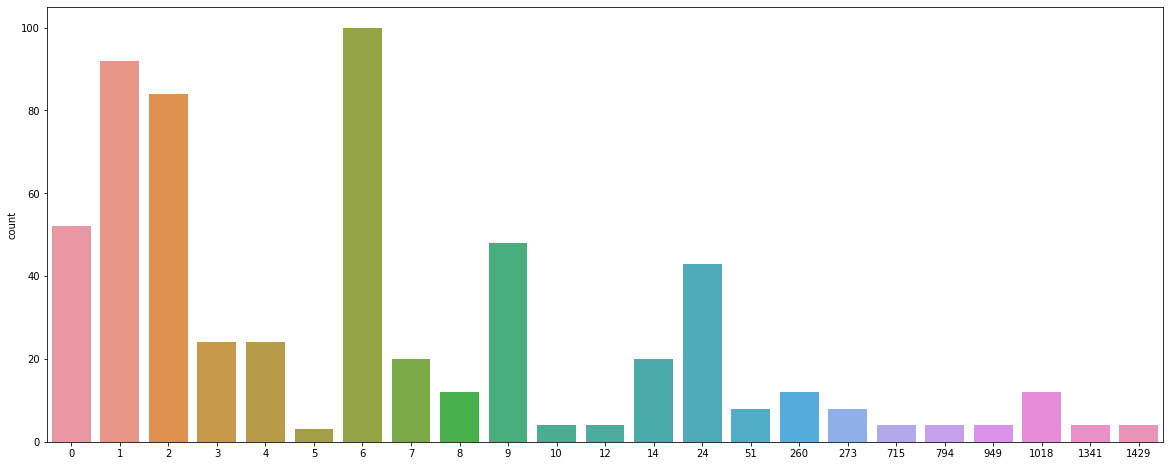

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df.isnull().sum())
plt.savefig("Countplot_null.jpg")

From the above countplot we can decide the threshold to drop the null values.

In [ ]:
df=remove_nan(df, threshold=0.03)

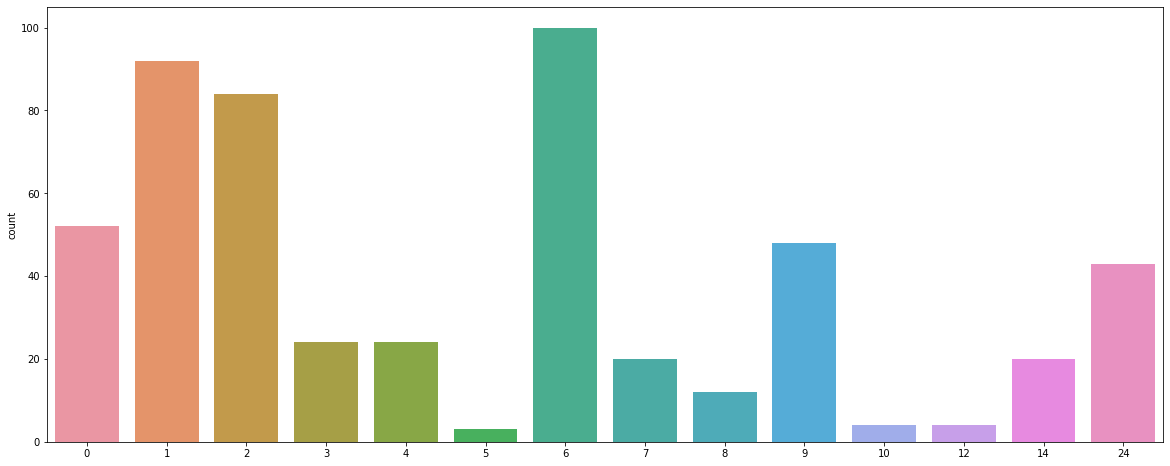

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(df.isnull().sum())
plt.savefig('countplot_afterdrop.jpg')

**KNN Imputer**

In [ ]:
from sklearn.impute import KNNImputer
r=[]
z2=df.copy()
ls=df.columns.values
for i in range(1,15):
  z1=df[ls]
  imputer = KNNImputer(n_neighbors=i)
  z1=imputer.fit_transform(z1)
  z1=pd.DataFrame(z1,columns=ls)
  r.append(max(z2.var()-z1.var()))
idx = r.index(min(r)) + 1           #Optimal Nearest Neighbor
 

From the above, we are finding the optimal nearest neighbour for which filling the missing data through KNN imputer results in lowest change in variance.

In [ ]:

df=knn_impute(df,k=idx)
df=remove_constant(df)
df.shape

(1567, 414)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

df=varianceThreshold(df,threshold=0.20)
df.shape

(1567, 224)

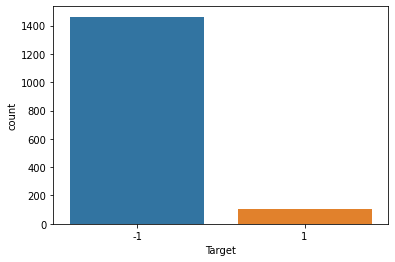

In [ ]:
sns.countplot(df1['Target'])
plt.savefig('Count target.jpg')

The above countplot shows the unbalancing between the two classes.

Selecting best number of features using ANOVA test

In [ ]:
xr=[]
for i in range(25,66):
  xt=k_best(df,df1,seat=i)
  df_label=df1.replace(-1,0)
  rec,prec = ANN(xt,df_label,xt.shape[1],20,{0:1,1:2}) 
  xr.append([i,rec,prec])


In [ ]:
xr

[[25, 0.761904776096344, 0.10958904027938843],
 [26, 0.7142857313156128, 0.14018692076206207],
 [27, 0.761904776096344, 0.12903225421905518],
 [28, 0.8095238208770752, 0.10967741906642914],
 [29, 0.761904776096344, 0.11347517371177673],
 [30, 0.761904776096344, 0.14414414763450623],
 [31, 0.761904776096344, 0.1355932205915451],
 [32, 0.8095238208770752, 0.1349206417798996],
 [33, 0.7142857313156128, 0.15306122601032257],
 [34, 0.6666666865348816, 0.1428571492433548],
 [35, 0.761904776096344, 0.1355932205915451],
 [36, 0.761904776096344, 0.14035087823867798],
 [37, 0.761904776096344, 0.14814814925193787],
 [38, 0.761904776096344, 0.12800000607967377],
 [39, 0.7142857313156128, 0.1376146823167801],
 [40, 0.523809552192688, 0.1964285671710968],
 [41, 0.8095238208770752, 0.1328125],
 [42, 0.6190476417541504, 0.16049382090568542],
 [43, 0.6666666865348816, 0.16091954708099365],
 [44, 0.6666666865348816, 0.15217390656471252],
 [45, 0.761904776096344, 0.15238095819950104],
 [46, 0.66666668653

In [ ]:
best_feat = k_best(df,df1,seat=49)

Selecting best number of features using Select from model

In [ ]:
model_feat=F_LogisticRegression(df,df1,'LogisticRegression')

**Model Evaluation using Machine Learning (Xgb, RF, LR, SVC)**

In [ ]:
Classification(best_feat,df1,"XGB")

accuracy of each fold - [0.9401709401709402, 0.9871794871794872, 0.9871794871794872, 0.9743589743589743, 0.9444444444444444, 0.9743589743589743, 0.9829059829059829, 0.9829059829059829, 0.9658119658119658, 0.9829059829059829]
Avg accuracy : 0.9722222222222223


precision of each fold - [0.9422385321100919, 0.9874999999999999, 0.9874999999999999, 0.975609756097561, 0.9500000000000001, 0.975609756097561, 0.9834710743801652, 0.9834710743801652, 0.9670402109426499, 0.9834710743801652]
Avg precision : 0.9735911478388359


recall of each fold - [0.9401709401709402, 0.9871794871794872, 0.9871794871794872, 0.9743589743589743, 0.9444444444444444, 0.9743589743589743, 0.9829059829059829, 0.9829059829059829, 0.9658119658119658, 0.9829059829059829]
Avg recall : 0.9722222222222223


Classification Report Training: 
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1170
           1       1.00      1.00      1.00      1170

    accuracy           

**Prediction through ANN**

In [ ]:
df_label=df1.replace(-1,0)

In [ ]:
ANN(best_feat,df_label,best_feat.shape[1],20,{0:1,1:2})  #{0:1,1:2}

Epoch 1/20
74/74 [==============================] - 1s 6ms/step - loss: 0.9729 - recall_84: 0.9957 - precision_73: 0.5006 - val_loss: 0.8225 - val_recall_84: 1.0000 - val_precision_73: 0.0686
Epoch 2/20
74/74 [==============================] - 0s 2ms/step - loss: 0.9244 - recall_84: 0.9991 - precision_73: 0.5328 - val_loss: 0.7550 - val_recall_84: 0.8095 - val_precision_73: 0.0876
Epoch 3/20
74/74 [==============================] - 0s 2ms/step - loss: 0.8806 - recall_84: 0.9718 - precision_73: 0.6038 - val_loss: 0.8295 - val_recall_84: 0.8571 - val_precision_73: 0.0874
Epoch 4/20
74/74 [==============================] - 0s 2ms/step - loss: 0.8464 - recall_84: 0.9513 - precision_73: 0.6400 - val_loss: 0.8483 - val_recall_84: 0.8571 - val_precision_73: 0.0874
Epoch 5/20
74/74 [==============================] - 0s 2ms/step - loss: 0.8298 - recall_84: 0.9419 - precision_73: 0.6567 - val_loss: 0.6879 - val_recall_84: 0.7143 - val_precision_73: 0.1145
Epoch 6/20
74/74 [======================

(0.6666666865348816, 0.1428571492433548)